Script to do meta-connectivity in two parts. First part: Homotopic connectivity analysis. Second part: cluster analysis

### The homotopic connectivity

In [ ]:
#!/usr/bin/python
from turtle import color
import pandas as pd
import numpy as np
import sys
sys.path.append('/mnt/c/Users/Wayne/tvb/Network-science-Toolbox/Python')
# sys.path.append('/home/wayne/github/TVB_workflow/new_g_optimal')
# sys.path.append('/home/wayne/github/Network-science-Toolbox/Python')
from TS2dFCstream import TS2dFCstream
from dFCstream2Trimers import dFCstream2Trimers
from dFCstream2MC import dFCstream2MC
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.stats import pearsonr
import itertools
import os
import scipy.io

plat4 = "desktop"

"""
@Author: Yile Wang

This script is used to calculate the homotopic meta-connectivity in four groups, SNC, NC, MCI, AD
"""

# brain region labels for your reference
regions = ['aCNG-L', 'aCNG-R','mCNG-L','mCNG-R','pCNG-L','pCNG-R', 'HIP-L','HIP-R','PHG-L','PHG-R','AMY-L','AMY-R', 'sTEMp-L','sTEMP-R','mTEMp-L','mTEMp-R']
regionswithgroups = ['groups','aCNG-L', 'aCNG-R','mCNG-L','mCNG-R','pCNG-L','pCNG-R', 'HIP-L','HIP-R','PHG-L','PHG-R','AMY-L','AMY-R', 'sTEMp-L','sTEMP-R','mTEMp-L','mTEMp-R']
group = ['SNC', 'NC', 'MCI','AD']
regionsHalf = np.array(['aCNG', 'mCNG','pCNG','HIP','PHG','AMY','sTEMp', 'mTEMp'])

regions14 = []
for i in range(14):
    wt = ["regions_", str(i)]
    wt = "".join(wt)
    regions14.append(wt)

# iterate simulated functional connectivity
if __name__ == "__main__":
    Trimer_Homo = pd.DataFrame(columns=['groups','trimer_homo','aCNG','mCNG','pCNG','HIP','PHG','AMY','sTEMp','mTEMp' ])
    Trimer_Hetero  = pd.DataFrame(columns=['groups','trimer_hetero','aCNG','mCNG','pCNG','HIP','PHG','AMY','sTEMp','mTEMp' ])
    Trimer = pd.DataFrame()
    
    for grp in group:
        # subject case ids
        if plat4 == "desktop":
            ldir = os.listdir("/mnt/c/Users/Wayne/tvb/TS-4-Vik/"+ grp+'-TS')
        elif plat4 == "laptop":
            ldir = os.listdir("/home/yat-lok/workspace/data4project/lateralization/ts_fmri/"+ grp+'-TS')
        # ldir = os.listdir('/home/wayne/TS-4-Vik/'+grp+'-TS/')
        MC_all = np.zeros((16,16, 16, len(ldir)))
        tmp_homo = np.array([])
        homoRegions = np.ones((1,len(regionsHalf)))
        for ind, y in enumerate(ldir):
            # import empirical functional connectivity
            # Here is the path of the mat file of the FC data
            if plat4 == "desktop":
                pth_efc = "/mnt/c/Users/Wayne/tvb/TS-4-Vik/"+ grp+'-TS/'+ y +"/ROISignals_"+ y +".mat"
            elif plat4 == "laptop":
                pth_efc = "/home/yat-lok/workspace/data4project/lateralization/ts_fmri/"+ grp+'-TS/'+ y +"/ROISignals_"+ y +".mat"
            # pth_efc = "/home/wayne/TS-4-Vik/"+grp+"-TS/"+ y +"/ROISignals_"+ y +".mat"
            ea = scipy.io.loadmat(pth_efc)
            all = ea['ROISignals']
            df = pd.DataFrame.from_dict(all)
            df.columns = regions
            # calculate the meta-connectivity, using existing script:
            dFCstream = TS2dFCstream(df.to_numpy(), 5, None, '2D')
            # Calculate MC
            MC_MC = dFCstream2MC(dFCstream)
            # Calculate Trimers results, with nxnxn information
            MC_all[:,:,:,ind] = dFCstream2Trimers(dFCstream)
        MC_homo = np.mean(MC_all, 3)
        MC_single_groups = np.zeros((14, 8))
        # only pick up L sides of the regions
        for idnx, i in enumerate(range(0,15,2)):
            j = i+1 # represent R side
            newList = list(range(16))
            del newList[i:j+1] # drop the target regions L and R
            for idx, restNode in enumerate(newList):
                MC_single_groups[idx,idnx] = MC_homo[i,j,restNode] # In rest of the 14 regions, iternate the third dimensions, and pick up the homotopic MC
        MC_single = pd.DataFrame(MC_single_groups, index=regions14, columns=regionsHalf)
        grpInfo = [grp] * 14
        MC_single.insert(0, "group", grpInfo)
        Trimer = Trimer.append(MC_single)
    # Trimer.to_excel("/mnt/c/Users/Wayne/tvb/gc1sec_res/mc_homo.xlsx")

### The clustering

step 1, data preprocessing

In [131]:
#!/usr/bin/python
from turtle import color
import pandas as pd
import numpy as np
import sys
sys.path.append('/home/yat-lok/workspace/Network-science-Toolbox/Python')
# sys.path.append('/home/wayne/github/TVB_workflow/new_g_optimal')
# sys.path.append('/home/wayne/github/Network-science-Toolbox/Python')
from TS2dFCstream import TS2dFCstream
from dFCstream2Trimers import dFCstream2Trimers
from dFCstream2MC import dFCstream2MC
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.stats import pearsonr
import itertools
import os
import scipy.io

# label = '/mnt/c/Users/Wayne/tvb/gc1sec_res/meta/Region_Labels_90ROIs.txt'
# list_ = open(label).read().split()
# region = list_[1::2]

regions = ['aCNG-L', 'aCNG-R','mCNG-L','mCNG-R','pCNG-L','pCNG-R', 'HIP-L','HIP-R','PHG-L','PHG-R','AMY-L','AMY-R', 'sTEMp-L','sTEMP-R','mTEMp-L','mTEMp-R']
group = ['SNC', 'NC', 'MCI','AD']
# path = '/mnt/c/Users/Wayne/tvb/stat_data/Gc_Go.xlsx'

# combination set
comba = list(itertools.combinations(range(len(regions)), 2))
# give labels to comba
comba_with_name = []
for x in comba:
    tmp_one = (regions[x[0]], regions[x[1]])
    comba_with_name.append(tmp_one)


path = '/home/yat-lok/workspace/data4project/lateralization/tvb_parameters.xlsx'
coData = pd.read_excel(path, index_col=0)

djouya_index = scipy.io.loadmat('/home/yat-lok/workspace/data4project/lateralization/gc1sec_res/meta/idx.mat')
mc_index = djouya_index['idx'].T[0] -1

module_ci = []
for i in range(120):
    if i < 20:
        module_ci.append(1)
    elif i >=20 and i < 40:
        module_ci.append(2)
    elif i >=40 and i < 60:
        module_ci.append(3)
    elif i >= 60 and i < 75:
        module_ci.append(4)
    else:
        module_ci.append(5)


edge_num = int((len(regions)*(len(regions)-1)) / 2)
mc_all = np.zeros((edge_num,edge_num, len(group)))
for id, grp in enumerate(group):
    mc_subject = np.zeros((edge_num,edge_num, len(coData.index[coData.groups == grp])))
    for ind, y in enumerate(coData.index[coData.groups == grp]):
        # import empirical functional connectivity
        # Here is the path of the mat file of the FC data
        # ldir = "/mnt/c/Users/Wayne/tvb/TS-4-Vik/"+ grp+'-TS/'+ y +"/ROISignals_"+ y +".mat"
        ldir = "/home/yat-lok/workspace/data4project/lateralization/ts_fmri/"+ grp+'-TS/'+ y +"/ROISignals_"+ y +".mat"
        ea = scipy.io.loadmat(ldir)
        all = ea['ROISignals']
        df = pd.DataFrame.from_dict(all)
        df.columns = regions
        dFCstream = TS2dFCstream(df.to_numpy(), 5, None, '2D')
        _mc = dFCstream2MC(dFCstream)
        # sort the matrix
        mc_single = np.zeros((len(mc_index),len(mc_index)))
        for mc_row in range(len(mc_index)-1):
            for mc_col in range(mc_row+1,len(mc_index)):
                mc_single[mc_row, mc_col] = _mc[mc_index[mc_row], mc_index[mc_col]]
        mc_sorted_single = mc_single + mc_single.T
        # ci, Q = community_louvain(mc_sorted_single, gamma=1.1, ci=module_ci, B='negative_asym', seed=None)
        # pos,_ = participation_coef_sign(mc_sorted_single, module_ci)
        # mc_single = np.zeros((len(mc_index),len(mc_index)))
        # for mc_row in range(len(mc_index)-1):
        #     for mc_col in range(mc_row+1,len(mc_index)):
        #         mc_single[mc_row, mc_col] = _mc[ci[mc_row], ci[mc_col]]
        # mc_sorted_single = mc_single + mc_single.T
        # Calculate MC & write to matrix
        mc_subject[:,:,ind] = mc_sorted_single
    mc_all[:,:,id] = np.mean(mc_subject, axis=2)



step 2, louvain algorithm for community check

In [134]:
# calculate the cluster
import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import pandas as pd
from bct.algorithms import community_louvain
from bct.algorithms.centrality import participation_coef_sign

group = ['SNC', 'NC', 'MCI','AD']
regions = ['aCNG-L', 'aCNG-R','mCNG-L','mCNG-R','pCNG-L','pCNG-R', 'HIP-L','HIP-R','PHG-L','PHG-R','AMY-L','AMY-R', 'sTEMp-L','sTEMP-R','mTEMp-L','mTEMp-R']
node_dict = {0:'aCNG-L', 1:'aCNG-R',2: 'mCNG-L',3:'mCNG-R',4:'pCNG-L',5:'pCNG-R', 6:'HIP-L',7:'HIP-R',8:'PHG-L',9:'PHG-R',10:'AMY-L',11:'AMY-R', 12:'sTEMp-L',13:'sTEMp-R',14:'mTEMp-L',15:'mTEMp-R'}



def mat_preprocessing(mat, group_index, labels):
    mat = pd.DataFrame(mat[:,:,group_index], columns=labels, index=labels)
    return mat


overall_df = pd.DataFrame()
for ind in range(len(group)):
    mat = mat_preprocessing(mc_all, ind, labels=np.array(comba_with_name)[mc_index])
    ci, Q = community_louvain(mat.to_numpy(), ci=module_ci, gamma = 1.5, B='negative_asym', seed=None)
    # fisrt method:
    pos,_ = participation_coef_sign(mat.to_numpy(), module_ci)
    ci_name_list = ["cluster_" + str(i) for i in module_ci]
    cluster_info = pd.DataFrame(ci_name_list)
    cluster_info.columns = ["cluster"]
    part_coe = pd.DataFrame(pos)
    part_coe.columns = ["participation_coef"]
    grp_info = pd.Series([group[ind]])
    grp_col = grp_info.repeat(len(mat.index))
    grp_col = grp_col.reset_index(drop=True)
    _tmp = pd.concat([grp_col, part_coe, cluster_info],axis=1, ignore_index=True)
    overall_df = pd.concat([overall_df, _tmp], ignore_index=True)
overall_df.columns = ["group","participation_coef", "cluster"]
overall_df.to_excel("/home/yat-lok/workspace/data4project/lateralization/gc1sec_res/meta/participation_coef.xlsx")




# def links_single_module(ci, cluster_index):
#     #bctpy
#     links_within_m = [item for item in np.where(ci==cluster_index)[0]]
#     return links_within_m

# def participation_coef_single_cluster(mat, links_within_m):
#     participation_coef_single = []
#     for i in range(len(links_within_m)):
#         drop_links_within = [ele for ele in links_within_m if ele not in [i]]
#         drop_links_outside = [ele for ele in range(len(mat.index)) if ele not in [i]]
#         n_l = np.sum(mat.iloc[drop_links_outside, links_within_m[i]])
#         single_link = []
#         for j in range(len(drop_links_within)):
#             n_l_within_m = np.sum(mat.iloc[drop_links_within[j], links_within_m[i]])
#             _value = (n_l_within_m/n_l)**2
#             single_link.append(_value)
#         pl=1 - np.sum(single_link)
#         participation_coef_single.append(pl)
#     return participation_coef_single

# second method:
#     single_grp_all_clusters = {}
#     for cii in range(1,max(ci)+1):
#         links_within_m = links_single_module(ci, cii)
#         participation_coef_single = participation_coef_single_cluster(mat, links_within_m)
#         str_name = "cluster_"+str(cii)
#         single_grp_all_clusters[str_name] = participation_coef_single
#     keys_list = list(single_grp_all_clusters.keys())


#     all_clusters_df = pd.DataFrame()
#     for ii in range(len(keys_list)):
#         _tmp = pd.DataFrame({keys_list[ii]:single_grp_all_clusters[keys_list[ii]]})
#         _tmp.columns = ["participation_coef"]
#         cluster_info = pd.Series([keys_list[ii]])
#         cluster_col = cluster_info.repeat(len(_tmp))
#         cluster_col = cluster_col.reset_index(drop=True)
#         _tmp_grp = pd.concat([_tmp, cluster_col], axis=1, ignore_index=True)
#         all_clusters_df = pd.concat([all_clusters_df,_tmp_grp], ignore_index=True)

#     grp_info = pd.Series([group[ind]])
#     grp_col = grp_info.repeat(len(mat.index))
#     grp_col = grp_col.reset_index(drop=True)
#     all_clusters_df = pd.concat([grp_col,all_clusters_df], axis=1, ignore_index=True)
#     all_clusters_df.columns = ["group","participation_coef", "cluster"]
#     overall_df = pd.concat([overall_df, all_clusters_df], ignore_index=True)
# overall_df.to_excel("/mnt/c/Users/Wayne/tvb/gc1sec_res/meta/participation_coef.xlsx")


# ### create edge network
# G = nx.Graph()
# G.add_edges_from(edge)

# ### retrun partition as a dict
# partition = community_louvain.best_partition(G)

[Text(0, 0, '0'),
 Text(20, 0, '20'),
 Text(40, 0, '40'),
 Text(60, 0, '60'),
 Text(80, 0, '80'),
 Text(100, 0, '100')]

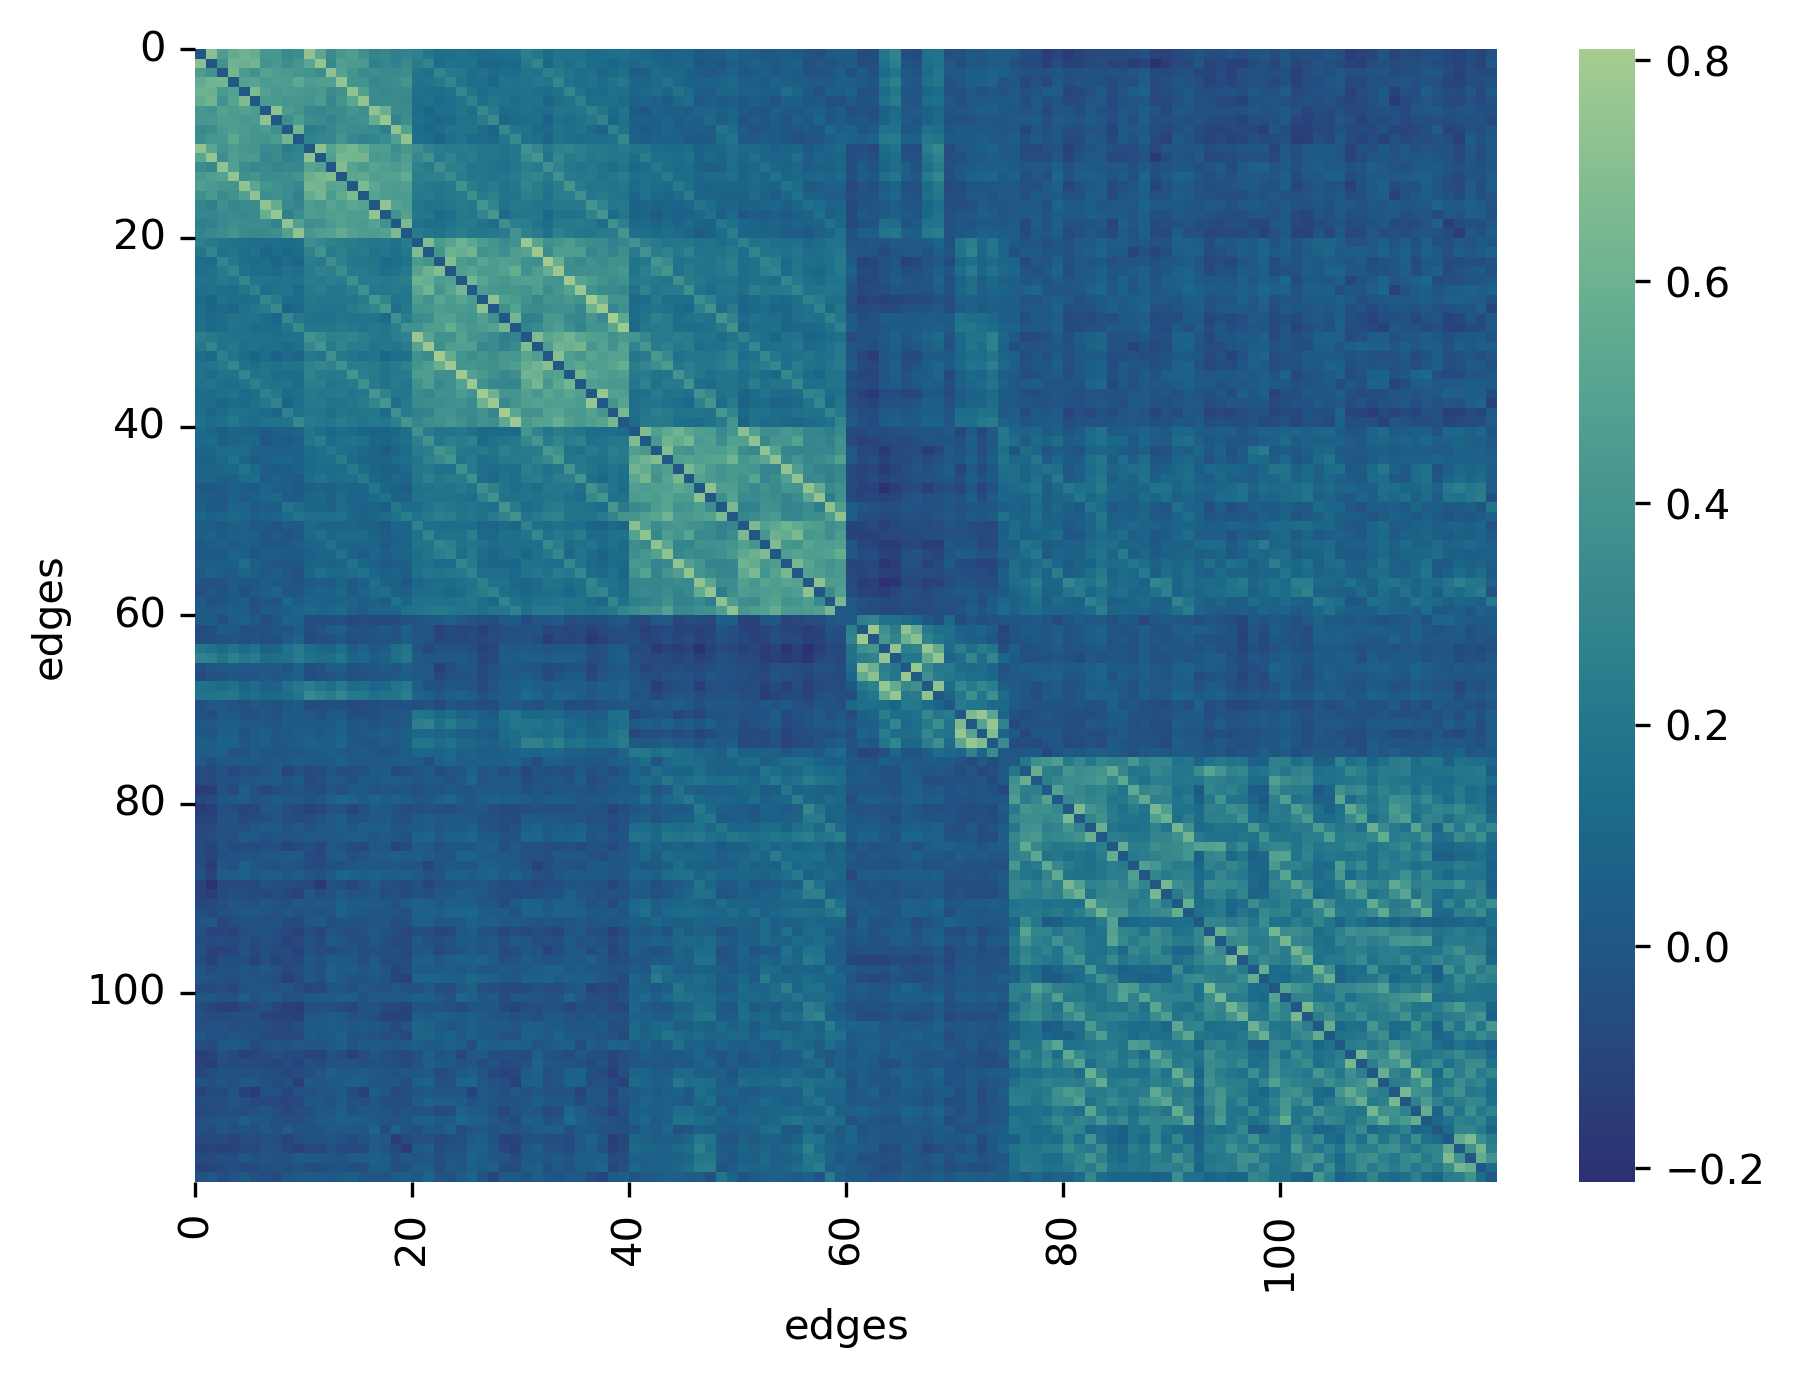

In [142]:
# ci, Q = community_louvain(mc_all[:,:,1], gamma=1.1, ci=module_ci, B='negative_asym', seed=None)
# mc_plot=np.zeros((120,120))
# for mc_row in range(120-1):
#     for mc_col in range(mc_row+1,120):
#         mc_plot[mc_row, mc_col] = mc_all[:,:,1][ci[mc_row], ci[mc_col]]
# mc_sorted_single = mc_single + mc_single.T


fig=plt.figure(figsize=(7,5), dpi=300)
axes = fig.add_subplot(111)
sns.heatmap(mc_all[:,:,1],cmap="crest_r", ax=axes)
axes.set_ylabel("edges")
axes.set_xlabel("edges")
axes.set_yticks(np.arange(0,121,20))
axes.set_xticks(np.arange(0,121,20))
axes.set_yticklabels(np.arange(0,121,20))
axes.set_xticklabels(np.arange(0,121,20))
